# Line Detector

In [189]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

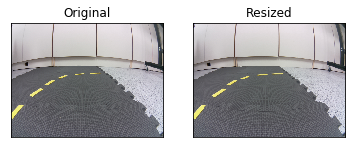

In [190]:
img = cv2.imread('images/curve-right.jpg')
img_cv = cv2.resize(img, (160,120), interpolation=cv2.INTER_NEAREST)
dst1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst2 = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
plt.subplot(121), plt.imshow(dst1, cmap='brg'),plt.xticks([]) ,plt.yticks([]),plt.title('Original')
plt.subplot(122),plt.imshow(dst2, cmap='brg'), plt.xticks([]), plt.yticks([]),plt.title('Resized')
plt.show()

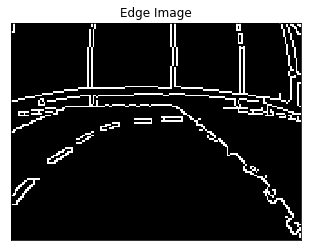

In [191]:
gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 90, 350)
plt.imshow(edges, cmap='gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [192]:
hsv_white1 = np.array([0,0,150])
hsv_white2 = np.array([170,100,255])
hsv_yellow1 = np.array([23,50,50])
hsv_yellow2 = np.array([45,255,255])

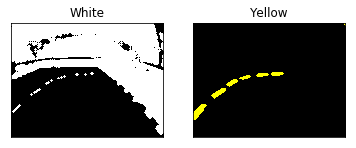

In [193]:
hsv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HSV)
white = cv2.inRange(hsv, hsv_white1, hsv_white2)
yellow = cv2.inRange(hsv, hsv_yellow1, hsv_yellow2)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
white = cv2.dilate(white, kernel)
yellow = cv2.dilate(yellow, kernel)
x = cv2.cvtColor(yellow, cv2.COLOR_GRAY2BGR)
x[:,:,0] *= 0 # B
x[:,:,1] *= 1 # G
x[:,:,2] *= 1 # R
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
plt.subplot(121), plt.imshow(white, cmap = 'gray'), plt.xticks([]),plt.yticks([]), plt.title('White')
plt.subplot(122), plt.imshow(x, cmap='brg'), plt.xticks([]), plt.yticks([]), plt.title('Yellow')
plt.show()

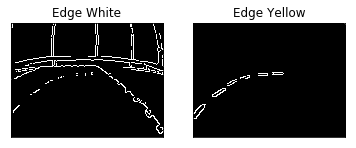

In [194]:
edge_white = cv2.bitwise_and(edges, white)
edge_yellow = cv2.bitwise_and(edges, yellow)

plt.subplot(121), plt.imshow(edge_white, cmap= 'gray'), plt.xticks([]), plt.yticks([]), plt.title('Edge White')
plt.subplot(122), plt.imshow(edge_yellow, cmap= 'gray'), plt.xticks([]), plt.yticks([]), plt.title('Edge Yellow')
plt.show()

In [195]:
lines_white = cv2.HoughLinesP(edge_white,1,np.pi/180,10,np.empty(1),1.5,1)
lines_yellow = cv2.HoughLinesP(edge_yellow,1,np.pi/180,10,np.empty(1),1.5,1)
lines_yellow = np.array(lines_yellow[0])
lines_white = np.array(lines_white[0])

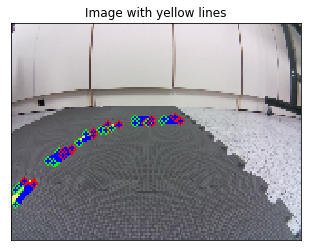

In [196]:
image_with_lines = np.copy(dst2)
for x1,y1,x2,y2 in lines_yellow:
    cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 0, 255), 2) # Blue
    cv2.circle(image_with_lines, (x1, y1), 2, (0,255,0)) # Green
    cv2.circle(image_with_lines, (x2, y2), 2, (255, 0, 0)) #Red
plt.imshow(image_with_lines, cmap= 'brg'), plt.xticks([]), plt.yticks([]), plt.title('Image with yellow lines')
plt.show()

In [197]:
def checkBounds(val, bound):
    val[val<=0] = 0
    val[val>= bound] = bound - 1
    return val
def correctPixelOrdering(lines, normals):
    flag = ((lines[:,2]-lines[:,0])*normals[:,1] - (lines[:,3]-lines[:,1])*normals[:,0])>0
    for i in range(len(lines)):
        if flag[i]:
            x1,y1,x2,y2 = lines[i, :]
            lines[i, :] = [x2,y2,x1,y1]
    return lines
def findNormal(bw, lines):
    normals = []
    centers = []
    if len(lines)>0:
        length = np.sum((lines[:, 0:2] -lines[:, 2:4])**2, axis=1, keepdims=True)**0.5
        dx = 1.* (lines[:,3:4]-lines[:,1:2])/length
        dy = 1.* (lines[:,0:1]-lines[:,2:3])/length

        centers = np.hstack([(lines[:,0:1]+lines[:,2:3])/2, (lines[:,1:2]+lines[:,3:4])/2])
        x3 = (centers[:,0:1] - 3.*dx).astype('int')
        y3 = (centers[:,1:2] - 3.*dy).astype('int')
        x4 = (centers[:,0:1] + 3.*dx).astype('int')
        y4 = (centers[:,1:2] + 3.*dy).astype('int')
        x3 = checkBounds(x3, bw.shape[1])
        y3 = checkBounds(y3, bw.shape[0])
        x4 = checkBounds(x4, bw.shape[1])
        y4 = checkBounds(y4, bw.shape[0])
        flag_signs = (np.logical_and(bw[y3,x3]>0, bw[y4,x4]==0)).astype('int')*2-1
        normals = np.hstack([dx, dy]) * flag_signs
        correctPixelOrdering(lines, normals)
    return centers, normals

In [198]:
center_y, normal_y = findNormal(yellow, lines_yellow)


In [302]:
# Convert to normalized pixel coordinates
camera_mat = np.array([[320.85158016062445, 0.0, 314.69273040354966], [0.0, 324.4043947706543, 215.6323591153414],[0.0, 0.0, 1.0]])
projection_mat = np.array([[222.80029296875, 0.0, 312.7231767529156, 0.0], [0.0, 256.32537841796875, 205.0252118033677,0.0], [0.0, 0.0, 1.0, 0.0]])
intrinsic = camera_mat.dot(projection_mat)
intrinsic
#lines_world = lines_yellow * np.linalg.inv(mat)
mat = np.array([[7.14858261e+04,0],[0,8.31530793e+04]])
mat = np.linalg.inv(mat)
for x1,y1,x2,y2 in lines_yellow:
    

ValueError: operands could not be broadcast together with shapes (18,4) (2,2) 

49 59 53 56
2 92 7 88
33 70 24 77
26 71 33 69
12 88 6 94
93 54 83 54
41 61 45 60
68 53 77 53
45 62 37 66
84 53 90 52
5 89 7 87
20 76 28 71
28 73 23 77
74 55 68 55
12 89 2 100
54 58 52 59
77 55 75 55
59 56 55 58


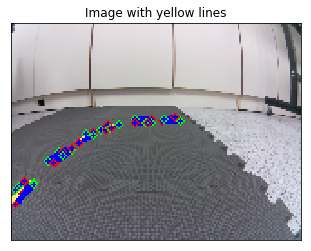

In [245]:
image_with_lines = np.copy(dst2)
count = 0
for x1,y1,x2,y2 in lines_yellow:
    cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 0, 255), 2) # Blue
    cv2.circle(image_with_lines, (x1, y1), 2, (0,255,0)) # Green
    cv2.circle(image_with_lines, (x2, y2), 2, (255, 0, 0)) #Red
    print x1,y1,x2,y2
plt.imshow(image_with_lines, cmap= 'brg'), plt.xticks([]), plt.yticks([]), plt.title('Image with yellow lines')
plt.show()

# Lane Filter

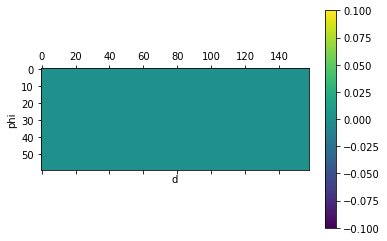

In [237]:
from math import pi, floor
d_min = -0.7
d_max = 0.5
delta_d = 0.02
phi_min = -pi/2
phi_max = pi/2
delta_phi = 0.02
d, phi = np.mgrid[d_min: d_max: delta_d, phi_min: phi_max: delta_phi]
measurement_likelihood = np.zeros(d.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(measurement_likelihood, interpolation='nearest')
fig.colorbar(cax)
plt.ylabel('phi')
plt.xlabel('d')

plt.show()

In [242]:
linewidth_white = 0.04
linewidth_yellow = 0.018
lanewidth = 0.3

for x1, y1, x2, y2 in lines_normalized_yellow:
    p1 = np.array([x1, y1])
    p2 = np.array([x2, y2])
    print p1,p2
    t_hat = (p2-p1)/np.linalg.norm(p2-p1)
    n_hat = np.array([-t_hat[1],t_hat[0]])   
    d1 = np.inner(n_hat,p1)
    d2 = np.inner(n_hat,p2)
    l1 = np.inner(t_hat,p1)
    if l1 < 0: l1 = - l1
    l2 = np.inner(t_hat,p2)
    if l2 < 0: l2 = - l2
    l_i = (l1+l2)/2
    d_i = (d1+d2)/2
    phi_i = np.arcsin(t_hat[1])
    if (p2[0] > p1[0]): # left edge of yellow lane
        d_i = d_i - linewidth_yellow
        phi_i = -phi_i
    else: # right edge of white lane
        d_i = -d_i
    d_i =  lanewidth/2 - d_i
    if d_i > d_max or d_i < d_min or phi_i < phi_min or phi_i>phi_max:
        continue
    print d_i,phi_i, l_i
    i = int(floor((d_i - d_min)/delta_d))
    j = int(floor((phi_i - phi_min)/delta_phi))
    measurement_likelihood[i,j] = measurement_likelihood[i,j] +  1/(l_i)


[ 0.40833333  0.61875   ] [ 0.44166667  0.6       ]
-0.571477369779 0.512389460311 0.0716666603768
[ 0.01666667  0.825     ] [ 0.05833333  0.8       ]
-0.54800659297 0.540419500271 0.385871816571
[ 0.275   0.6875] [ 0.2      0.73125]
-0.582412526387 0.528074448426 0.152286019768
[ 0.21666667  0.69375   ] [ 0.275    0.68125]
-0.555748393991 0.211093333223 0.0963251782916
[ 0.1  0.8] [ 0.05    0.8375]
-0.55 0.643501108793 0.43125
[ 0.775   0.5875] [ 0.69166667  0.5875    ]
-0.4375 0.0 0.733333333333
[ 0.34166667  0.63125   ] [ 0.375  0.625]
-0.515403317478 0.185347949996 0.236439630906
[ 0.56666667  0.58125   ] [ 0.64166667  0.58125   ]
-0.41325 -0.0 0.604166666667
[ 0.375   0.6375] [ 0.30833333  0.6625    ]
-0.578581141296 0.358770670271 0.0916822319703
[ 0.7      0.58125] [ 0.75   0.575]
-0.495585830052 0.124354994547 0.647693879683
[ 0.04166667  0.80625   ] [ 0.05833333  0.79375   ]
-0.502 0.643501108793 0.44
[ 0.16666667  0.725     ] [ 0.23333333  0.69375   ]
-0.559196707942 0.438336

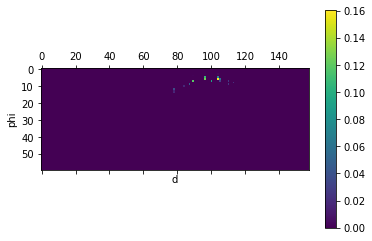

1052


In [243]:
measurement_likelihood = measurement_likelihood/np.sum(measurement_likelihood)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(measurement_likelihood, interpolation='nearest')
fig.colorbar(cax)
plt.ylabel('phi')
plt.xlabel('d')

plt.show()
print measurement_likelihood.argmax()

In [244]:
maxids = np.unravel_index(measurement_likelihood.argmax(),measurement_likelihood.shape)
d = d_min + maxids[0] * delta_d
phi = phi_min + maxids[1] * delta_phi
print d, phi

-0.58 0.509203673205
